In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [3]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=fffbdd28eaa256479fee0870be40af2f074fa8a5994ac41d50e63e7e54a7351d
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


# **Data Aquisition**

In [4]:
import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project AI/Detection_Real_4k_.csv")

In [6]:
df.sample(3)

,ID,News_Title,News_Text,Published_ Date,Source,Source_URL,Author,Country,Language,Other_Source,Other_Source_URL,News_Type,Party_Affiliation,Location,Region,Subject,Header_Image_URL,Label
1129,1129,Sindh Assembly passes prisons reform law,The Sindh Assembly passed on Friday the Sindh ...,18/05/2019,The Express Tribune,https://tribune.com.pk/story/1975677/sindh-ass...,Hafeez Tunio,Pakistan,English,Daily Times,https://dailytimes.com.pk/396942/sindh-jail-re...,Website,Others,Karachi,Sindh,Cultural Politics,https://i.tribune.com.pk/media/images/1975677-...,Real
3564,3564,Pakistan shares dossier on Indias terror campa...,Pakistan has handed over a dossier on Indias t...,25/11/2020,Dawn News,https://www.dawn.com/news/1592313,Dawn News News,Pakistan,English,Aljazeera,https://www.aljazeera.com/news/2020/11/25/paki...,Website,PTI,Islamabad,Punjab,International News,https://i.dawn.com/primary/2020/11/5fbe08eb60c...,Real
972,972,PM Imran summons cabinet meeting on Aug 6,Prime Minister Imran Khan has summoned a feder...,2/8/2019,Dunya News,https://dunyanews.tv/en/Pakistan/503452-PM-Imr...,Dunya News News,Pakistan,English,Abb Takk News,https://abbtakk.tv/en/pm-imran-summons-federal...,Website,Others,Islamabad,Federal,Democratic Politics,https://img.dunyanews.tv/news/2019/August/08-0...,Real


# **Exploratory data Analysis**

In [7]:
df.shape

(5161, 18)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5161 entries, 0 to 5160
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 5161 non-null   int64 
 1   News_Title         5161 non-null   object
 2   News_Text          5153 non-null   object
 3   Published_ Date    5160 non-null   object
 4   Source             5161 non-null   object
 5   Source_URL         5160 non-null   object
 6   Author             5161 non-null   object
 7   Country            5161 non-null   object
 8   Language           5161 non-null   object
 9   Other_Source       5161 non-null   object
 10  Other_Source_URL   5160 non-null   object
 11  News_Type          5161 non-null   object
 12  Party_Affiliation  5160 non-null   object
 13  Location           5159 non-null   object
 14  Region             5160 non-null   object
 15  Subject            5161 non-null   object
 16  Header_Image_URL   5158 non-null   object


In [9]:
df.isna().sum()

,0
ID,0
News_Title,0
News_Text,8
Published_ Date,1
Source,0
Source_URL,1
Author,0
Country,0
Language,0
Other_Source,0


In [10]:
df.duplicated().sum()

np.int64(0)

# **Data Visualization**

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

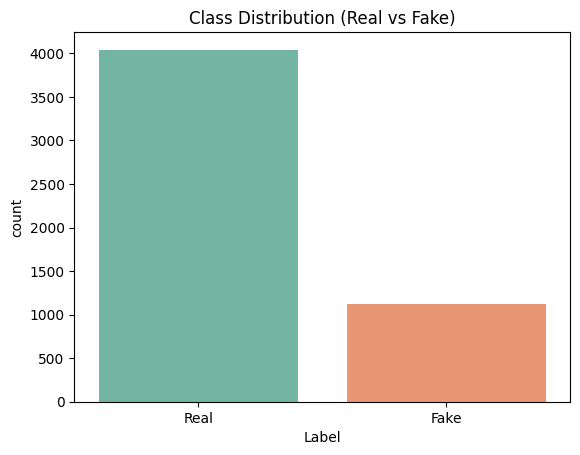

In [12]:
# Class Distribution Bar Plot

sns.countplot(x='Label', data=df, palette='Set2')
plt.title('Class Distribution (Real vs Fake)')
plt.show()

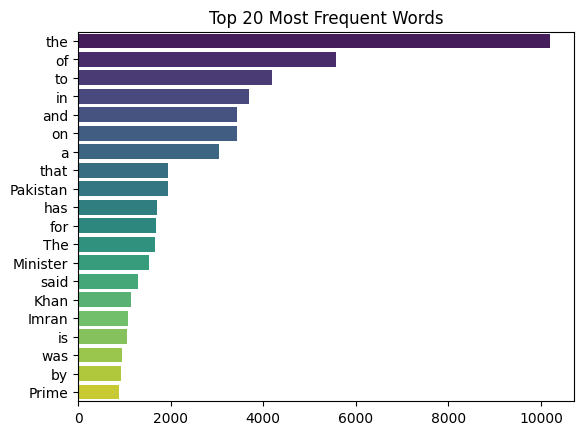

In [13]:
# Word Frequency Bar Plot

from collections import Counter

df['News_Text'] = df['News_Text'].fillna('').astype(str)

all_words = ' '.join(df['News_Text']).split()
word_freq = Counter(all_words).most_common(20)

words, counts = zip(*word_freq)

sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.show()


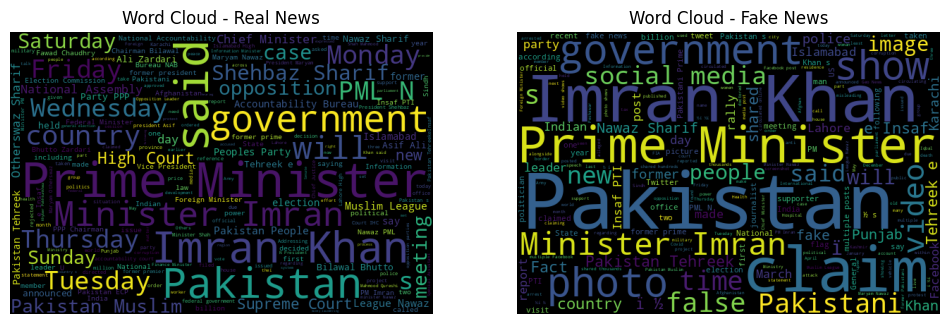

In [14]:
from wordcloud import WordCloud

real_text = ' '.join(df[df['Label']=='Real']['News_Text'].dropna().astype(str))
fake_text = ' '.join(df[df['Label']=='Fake']['News_Text'].dropna().astype(str))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(real_text))
plt.title('Word Cloud - Real News')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(fake_text))
plt.title('Word Cloud - Fake News')
plt.axis('off')

plt.show()

# **Data Cleaning and Preprocessing**

In [15]:
import re
from bs4 import BeautifulSoup
from langdetect import detect, DetectorFactory, LangDetectException
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [16]:
import nltk

resources = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'omw-1.4'
]

for r in resources:
    nltk.download(r)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [17]:
df = df.dropna(subset=['News_Text', 'Label']).copy()

In [18]:
label_map = {'Real': 0, 'Fake': 1, 0: 0, 1: 1}
df['Label'] = df['Label'].map(label_map)

In [19]:
DetectorFactory.seed = 0 # Set fixed seed to ensure reproducible language detection results

sample = df['News_Text'].dropna().sample(min(300, len(df)), random_state=42).astype(str).tolist()

langs = []
for x in sample:
    text = x.strip()[:500]
    try:
        if len(text) > 20:
            langs.append(detect(text))
        else:
            langs.append("unknown")
    except LangDetectException:
        langs.append("unknown")

pd.Series(langs).value_counts()

,count
en,298
unknown,1
id,1


In [20]:
lemmatizer = WordNetLemmatizer()

url_pattern = re.compile(r'https?://\S+|www\.\S+')
boilerplate_patterns = [ re.compile(r'subscribe|follow us|read more|advertisement|click here', re.I), ]
punct_table = str.maketrans('', '', r'!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~')

In [21]:
def clean_text_basic(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    text = url_pattern.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [22]:
def normalize_english(text: str) -> str:
    text = text.lower()
    for pat in boilerplate_patterns:
        text = pat.sub(' ', text)

    text = text.translate(punct_table)
    text = re.sub(r'\d+', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in ENGLISH_STOP_WORDS and len(t) > 2]

    return ' '.join(tokens)

In [23]:
def preprocess_text(text: str) -> str:
    base = clean_text_basic(text)
    if not base:
        return ""

    try:
        lang = detect(base[:500])
    except LangDetectException:
        lang = 'en'

    if lang == 'en':
        return normalize_english(base)
    elif lang in ('ur', 'fa', 'ar'):
        return normalize_urdu(base)
    else:
        return normalize_english(base)

In [24]:
df['content_clean'] = df['News_Text'].astype(str).apply(preprocess_text)
df['len_clean'] = df['content_clean'].str.split().apply(len)
df = df[df['len_clean'] >= 5].copy()

In [25]:
df = df.drop_duplicates(subset=['News_Title', 'content_clean']).copy()

In [26]:
print("Rows after cleaning:", len(df))

Rows after cleaning: 5095


In [27]:
print("Class balance after cleaning: \n", df['Label'].value_counts(normalize=True))

Class balance after cleaning: 
 Label
0    0.783513
1    0.216487
Name: proportion, dtype: float64


# **Feature Extraction**

In [28]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 92.7 MB/s eta 0:00:00


In [29]:
import gensim
from gensim.models import Word2Vec

In [30]:
tokenized_corpus = [text.split() for text in df['content_clean']]

In [31]:
SEED = 42 # Set random seed for reproducibility

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1,
    seed=SEED
)

In [32]:
w2v_model.save("word2vec_fake_news.model")

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class Word2VecEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model=w2v_model):
        self.model = model
        self.vector_size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        embeddings = []
        for doc in X.astype(str):
            tokens = doc.split()
            valid_tokens = [t for t in tokens if t in self.model.wv]
            if not valid_tokens:
                embeddings.append(np.zeros(self.vector_size))
            else:
                embeddings.append(np.mean(self.model.wv[valid_tokens], axis=0))
        return np.array(embeddings)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

w2v_branch = Pipeline(steps=[
    ('w2v', Word2VecEmbedder()),
    ('svd', TruncatedSVD(n_components=50, random_state=SEED))
])

In [35]:
text_features = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.9,
    ngram_range=(1,2),
    analyzer='word'
)

In [36]:
char_features = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.95,
    ngram_range=(3,5),
    analyzer='char'
)

In [37]:
preprocessor_w2v = ColumnTransformer(
    transformers=[
        ('word_tfidf', text_features, 'content_clean'),
        ('char_tfidf', char_features, 'content_clean'),
        ('word2vec', w2v_branch, 'content_clean')
    ],
    remainder='drop'
)

In [38]:
model_w2v = Pipeline(steps=[
    ('prep', preprocessor_w2v),
    ('clf', LogisticRegression(
        solver='liblinear',
        C=1.0,
        class_weight='balanced',
        max_iter=400
    ))
])

# **Modeling**

In [39]:
X = df.drop(columns=['Label'])
y = df['Label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=SEED )

In [40]:
model_w2v.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('word_tfidf',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=3,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  sublinear_tf=True),
                                                  'content_clean'),
                                                 ('char_tfidf',
                                                  TfidfVectorizer(analyzer='char',
                                                                  max_df=0.95,
                                                                  min_df=3,
                                                                  ngram_range=(3,
                                                                               5),
                                                                  sublinear_tf=True),
                                                  'content_clean'),
                                                 ('word2vec',
                                                  Pipeline(steps=[('w2v',
                                                                   Word2VecEmbedder()),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=50,
                                                                                random_state=42))]),
                                                  'content_clean')])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=400,
                                    solver='liblinear'))])

In [41]:
y_pred = model_w2v.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8812561334641805


In [42]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9237    0.9248    0.9242       798
           1     0.7273    0.7240    0.7256       221

    accuracy                         0.8813      1019
   macro avg     0.8255    0.8244    0.8249      1019
weighted avg     0.8811    0.8813    0.8812      1019



In [43]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[738  60]
 [ 61 160]]


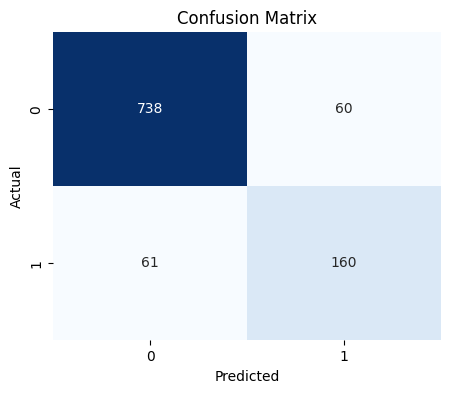

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# **Testing**

In [45]:
import joblib
joblib.dump(model_w2v , "fake_news_model_lr.joblib")

['fake_news_model_lr.joblib']

In [56]:
model_w2v = joblib.load("fake_news_model_lr.joblib")

input_text = pd.DataFrame({"content_clean": [
    "Imran Khan enquired about the administrations provision of medicines to patients and urged the administration to continue providing patients with standard healthcare services"
]})

prediction = model_w2v.predict(input_text)

print("Fake News" if prediction[0] == 1 else "Real News")


Real News


In [ ]:
Real: Imran Khan enquired about the administrations provision of medicines to patients and urged the administration to continue providing patients with standard healthcare services

In [ ]:
Fake: Pakistan will refuse to recognize Israel until Palestinian rights are guaranteed Prime Minister Imran Khan said in a television interview AFPFile Photo